In [1]:
from tensorflow.keras.layers import Input, Add, Conv2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Dense, MaxPooling2D
from tensorflow.keras.models import Model
from datasets import load_dataset
import cv2
import numpy as np
import os
from multiprocessing import Pool
from IPython.display import clear_output
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import random,os,glob
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.image as mp
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2


In [ ]:

IMG_HEIGHT, IMG_WIDTH = 224, 224
BASE_FOLDER = "dataset_1"
TRAIN_FOLDER = os.path.join(BASE_FOLDER, 'train')
VAL_FOLDER = os.path.join(BASE_FOLDER, 'val')
TEST_FOLDER = os.path.join(BASE_FOLDER, 'test')

os.makedirs(TRAIN_FOLDER, exist_ok=True)
os.makedirs(VAL_FOLDER, exist_ok=True)
os.makedirs(TEST_FOLDER, exist_ok=True)

ds = load_dataset("garythung/trashnet", streaming=True)

images = []
labels = []

for c, example in enumerate(ds['train']):
    img = np.array(example['image']) 

    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))  

    label = str(example["label"])

    images.append((img, label))
train_images, temp_images = train_test_split(images, test_size=0.2, random_state=42,startify=label)
val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42,startify=label)

def save_images(image_list, folder):
    for c, (img, label) in enumerate(image_list):
        label_folder = os.path.join(folder, label)
        os.makedirs(label_folder, exist_ok=True)
        
        file_path = os.path.join(label_folder, f"image_{c + 1}.jpg")
        cv2.imwrite(file_path, img)
        
        print(f"Saved image {c + 1} to {label_folder}")
        clear_output(wait=True)

save_images(train_images, TRAIN_FOLDER)
save_images(val_images, VAL_FOLDER)
save_images(test_images, TEST_FOLDER)


In [3]:
train_path = '/kaggle/input/data12/train/'
val_path = '/kaggle/input/data12/val/'
test_path = '/kaggle/input/data12/test/'

In [5]:
image_size = (224, 224)
batch_size = 64


train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30, zoom_range=0.2, horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=1
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=image_size,
    batch_size=476,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    batch_size=479,
    class_mode='categorical',
    shuffle=False
)

y_train = train_generator.classes
y_val = val_generator.classes
y_test = test_generator.classes


Found 4043 images belonging to 6 classes.
Found 505 images belonging to 6 classes.
Found 506 images belonging to 6 classes.


In [8]:
# np.save("images.npy", np.array(images))
# np.save("labels.npy", np.array(labels))

In [9]:
# d = {'images':images, 'labels': labels}

# df = pd.DataFrame(d)
# df = pd.read_csv("/kaggle/input/row-mat/Row_m.csv")


In [10]:
# df.head()

In [11]:
def residual_block(input_tensor, filters, strides=1, is_identity=True):
    
    filter1, filter2, filter3 = filters
    
    x = Conv2D(filter1, kernel_size=(1, 1), strides=strides, padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(filter2, kernel_size=3, strides=1, padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(filter3, kernel_size=(1, 1), strides=1, padding="same")(x)
    x = BatchNormalization()(x)
    
    if is_identity:
        shortcut = input_tensor
    else:
        shortcut = Conv2D(filter3, kernel_size=(1, 1), strides=strides, padding="same")(input_tensor)
        shortcut = BatchNormalization(axis=3)(shortcut)
    
    x = Add()([x, shortcut])
    x = ReLU()(x)
    
    return x

In [12]:
inputs = Input(shape=(224, 224, 3))

x=Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same')(inputs)
x=BatchNormalization()(x)
x=ReLU()(x)
x=MaxPooling2D(pool_size=3, strides=2, padding='same')(x)


In [13]:
x = residual_block(x, filters=(64, 64, 256), is_identity=False)
for _ in range(2):
    x = residual_block(x, filters=(64, 64, 256))

In [14]:

x = residual_block(x, filters=(128, 128, 512), strides=2, is_identity=False)

for _ in range(3):
    x = residual_block(x, filters=(128, 128, 512))



In [15]:
x = residual_block(x, filters=(256, 256, 1024), strides=2, is_identity=False)

for _ in range(5):
    x = residual_block(x, filters=(256, 256, 1024))

In [16]:
x = residual_block(x, filters=(512, 512, 2048), strides=2, is_identity=False)
for i in range(2):
    x = residual_block(x, filters=(512, 512, 2048))

In [17]:
x=GlobalAveragePooling2D()(x)
outputs = Dense(6, activation="softmax")(x)
model = Model(inputs, outputs)

In [18]:
# images = np.load('/kaggle/working/images.npy')
# labels = np.load('/kaggle/working/labels.npy')

In [19]:
# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True
# )
# train_generator = datagen.flow(
#     images, labels, 
#     batch_size=1
# )

In [20]:
# # Apply augmentation to train data and create data generators
# train_dataset = train_datagen.flow(train_images, train_labels, batch_size=32)
# val_dataset = test_datagen.flow(val_images, val_labels, batch_size=32)
# test_dataset = test_datagen.flow(test_images, test_labels, batch_size=32)

# # Print class indices
# labels = train_dataset.class_indices
# print(labels)

# # Inverse class mapping
# inverse_labels = {v: k for k, v in labels.items()}
# print(inverse_labels)

In [21]:
# img_array = (images - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]


In [22]:
# df = pd.DataFrame({
#     'image': list(images),  # Each row contains the 3D array for an image
#     'label': labels          # Labels are associated with the images
# })

In [23]:
# df.to_pickle("data.pkl")


In [24]:
# num_classes = len(np.unique(y_train))  # Adjust based on your dataset
# y_train = to_categorical(y_train, num_classes)
# y_test = to_categorical(y_test, num_classes)
# y_test

In [25]:
# import numpy as np
# from sklearn.utils import class_weight

# # Assuming you have a list of labels for your dataset, e.g., train_labels
# train_labels = train_generator.classes  # Replace with the list of your training labels

# # Calculate class weights based on the frequency of each class
# class_weights = class_weight.compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(train_labels),
#     y=train_labels
# )

# # Convert class weights to a dictionary
# class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
# print("Class weights:", class_weight_dict)


In [26]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │     16,640 │ re_lu_2[0][0]     │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     16,640 │ max_pooling2d[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 56, 56,    │          0 │ add[0][0]       

 Total params: 23,600,006 (90.03 MB)

 Trainable params: 23,546,886 (89.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [43]:
early_stopping = EarlyStopping(monitor='val_accuracy',patience=20, restore_best_weights=True)


optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['accuracy'])
# model.fit(x_train, y_train,validation_split=0.2, epochs=16, batch_size=16)

history = model.fit(
    train_generator,
    epochs=100, 
    validation_data=val_generator,
    # class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 102s 914ms/step - accuracy: 0.9149 - loss: 0.2600 - val_accuracy: 0.8119 - val_loss: 0.5517
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 49s 693ms/step - accuracy: 0.9247 - loss: 0.2288 - val_accuracy: 0.8218 - val_loss: 0.5322
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 48s 668ms/step - accuracy: 0.9268 - loss: 0.2247 - val_accuracy: 0.7663 - val_loss: 0.7617
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 48s 667ms/step - accuracy: 0.9276 - loss: 0.2170 - val_accuracy: 0.8119 - val_loss: 0.5680
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 48s 671ms/step - accuracy: 0.9269 - loss: 0.2098 - val_accuracy: 0.7861 - val_loss: 0.6851
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 48s 672ms/step - accuracy: 0.9272 - loss: 0.1961 - val_accuracy: 0.7624 - val_loss: 0.7881
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 48s 671ms/step - accuracy: 0.9319 - loss: 0.2066 - val_accuracy: 0.7267 - val_loss: 1.1758
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 48s 675ms/step - accuracy: 0.9382 - loss: 0.1903 -

In [44]:
model.save("model1.h5")

In [53]:
from tensorflow.keras.models import load_model

model1 = load_model("/kaggle/working/model1.h5")


In [54]:
model1.evaluate(test_generator)

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9034 - loss: 0.4378


[0.4379902780056, 0.9031620621681213]

In [55]:
index_order = test_generator.index_array

# Shuffle affects the index order; rearrange the true labels accordingly
y_true = test_generator.classes[index_order]
y_pred_probs = model1.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(y_pred_probs, axis=1) 


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step


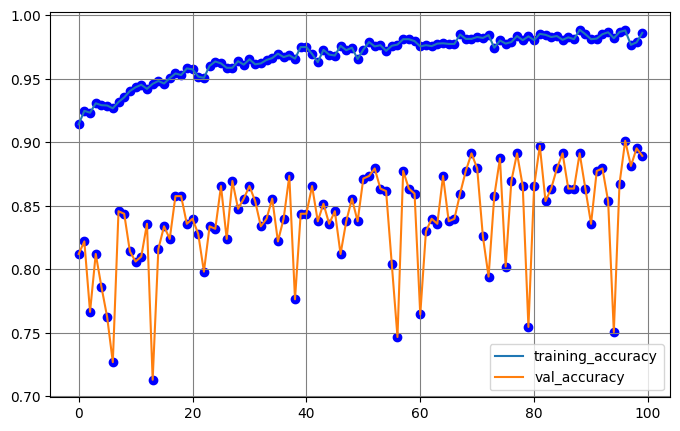

In [56]:
acc = history.history["accuracy"]
val_acc = history.history['val_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(8,5))
plt.plot(epochs, acc, label='training_accuracy')
plt.plot(epochs, val_acc, label='val_accuracy')
plt.scatter(epochs, acc, color='blue')
plt.scatter(epochs, val_acc, color='blue')
plt.grid(True, color='gray')
plt.legend()
plt.show()

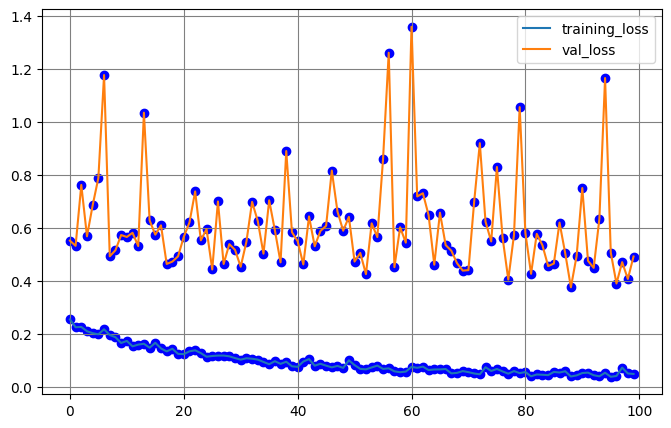

In [57]:
acc = history.history["loss"]
val_acc = history.history['val_loss']
# loss = history.history['loss']
# val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(8,5))
plt.plot(epochs, acc, label=f'training_loss')
plt.plot(epochs, val_acc, label=f'val_loss')
plt.scatter(epochs, acc, color='blue')
plt.scatter(epochs, val_acc, color='blue')
plt.grid(True, color='gray')
plt.legend()
plt.show()

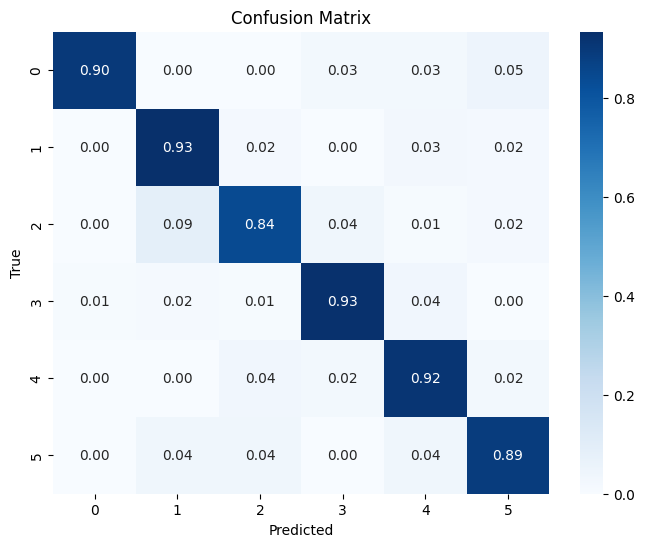

In [58]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=test_generator.class_indices.keys(), 
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

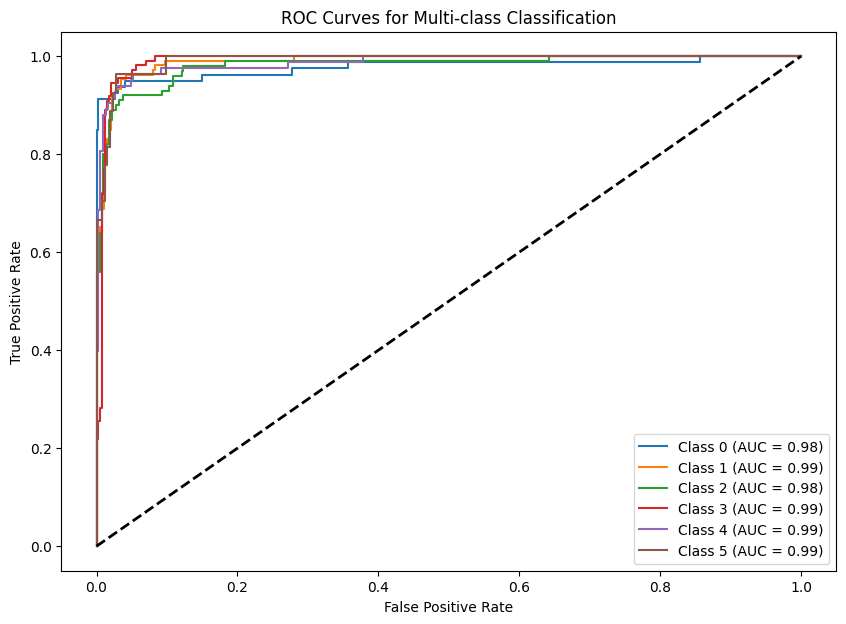

In [59]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
import numpy as np

# Assuming y_true and y_pred_proba are already defined
# y_true: true labels (not one-hot encoded)
# y_pred_proba: model predicted probabilities for each class

# Binarize the true labels for OvR (One-vs-Rest)
n_classes = len(set(y_true))  # Number of classes
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

# Initialize variables
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot random chance line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-class Classification')
plt.legend(loc="lower right")
plt.show()

In [60]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

# Assuming:
# y_true: true labels (1D array)
# y_pred: predicted labels (1D array)
# y_pred_proba: predicted probabilities (2D array)

n_classes = len(set(y_true))  # Number of classes

# Calculate Precision, Recall, and F1-Score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Calculate AUC for multi-class (using one-vs-rest approach)
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
auc = roc_auc_score(y_true_bin, y_pred_probs, average='weighted', multi_class='ovr')

# Print results
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

Precision: 0.9077
Recall: 0.9032
F1-Score: 0.9040
AUC: 0.9857
